In [2]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from audiomentations import Compose, TimeStretch, PitchShift, AddGaussianNoise
from tensorflow.keras.regularizers import l2

# Define paths and parameters
DATASET_PATH_TRAIN = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
DATASET_PATH_DEV = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac"
DATASET_PATH_EVAL = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_eval/flac"
LABEL_FILE_PATH_TRAIN = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
LABEL_FILE_PATH_DEV = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt"
LABEL_FILE_PATH_EVAL = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MFCC = 13  # Number of MFCC coefficients
HOP_LENGTH = 512  # Hop length for MFCC extraction
WIN_LENGTH = 1024  # Window length for MFCC extraction

2023-10-27 11:31:22.646991: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Convert the lists to NumPy arrays
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
y_dev = np.load('y_dev.npy')
y_eval = np.load('y_eval.npy')

In [4]:

# Convert lists to NumPy arrays
X_train_augmented_array = np.array(X_train_augmented)
X_dev_augmented_array = np.array(X_dev_augmented)
X_eval_augmented_array = np.array(X_eval_augmented)

# Save the NumPy arrays as .npy files
np.save('X_train_augmented.npy', X_train_augmented_array)
np.save('X_dev_augmented.npy', X_dev_augmented_array)
np.save('X_eval_augmented.npy', X_eval_augmented_array)

NameError: name 'X_train_augmented' is not defined

In [5]:
from sklearn.utils.class_weight import compute_class_weight


# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert the class weights to a dictionary
class_weight_dict = {i: class_weights[i] for i in range(NUM_CLASSES)}

In [6]:
print(X_train[0].shape)

#(13,109) - 13 mfcc coefficient, 109 steps

(13, 109)


https://www.kaggle.com/code/parulpandey/eda-and-audio-processing-with-python
consider baysian search
Can use principal component analysis (PCA) to reduce collinearity

https://www.worldscientific.com/doi/pdf/10.1142/S2196888822500300


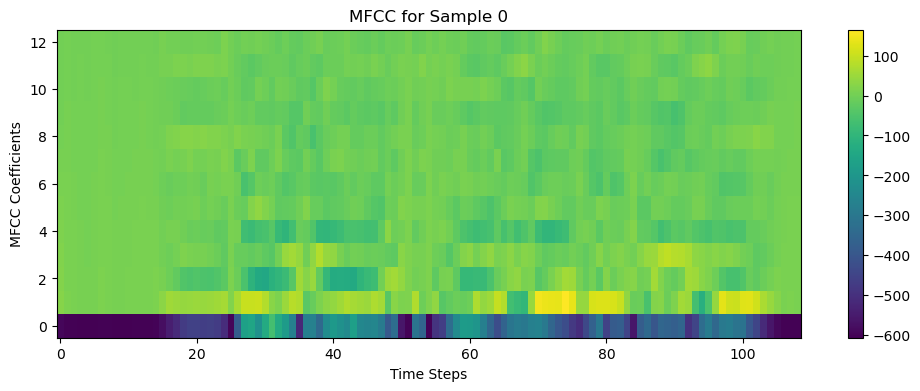

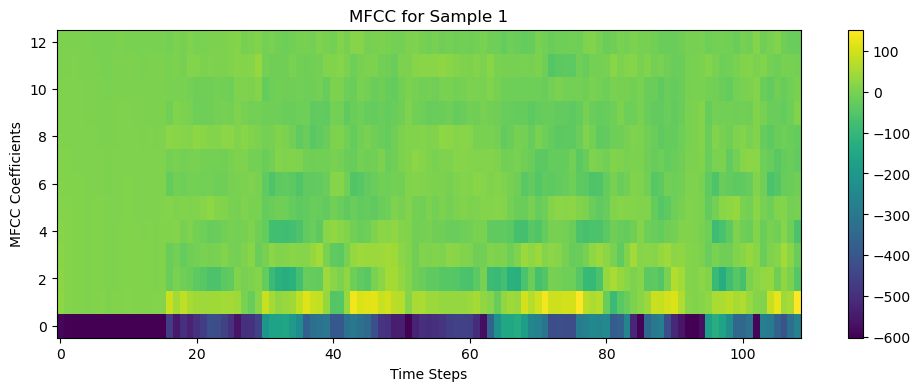

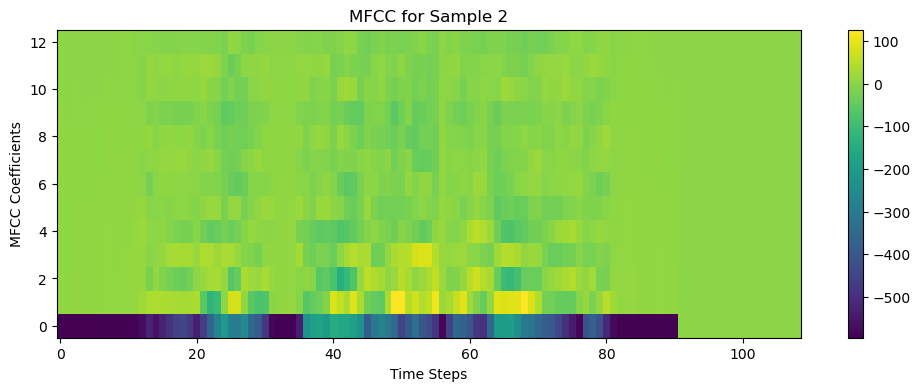

In [8]:
import matplotlib.pyplot as plt

# Plot MFCC for a single sample
sample_indexes = [0,1,2]
for i in sample_indexes:
    plt.figure(figsize=(12, 4))
    plt.imshow(X_train[i], origin='lower', aspect='auto', cmap='viridis')
    plt.title('MFCC for Sample {}'.format(i))
    plt.xlabel('Time Steps')
    plt.ylabel('MFCC Coefficients')
    plt.colorbar()
    plt.show()


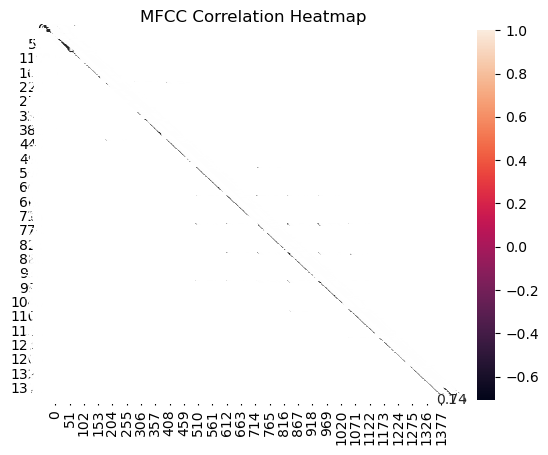

In [29]:
#audio analysis - right now, mfcc, consider using spectrogram
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
min_val = np.min(X_train, axis=0)
max_val = np.max(X_train, axis=0)

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = np.corrcoef(X_train.reshape(X_train.shape[0], -1), rowvar=False)

# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True)
plt.title('MFCC Correlation Heatmap')
plt.show()



In [30]:
threshold = 0.5  # Adjust this threshold as needed
strong_corr_matrix = np.where(np.abs(corr_matrix) > threshold, corr_matrix, 0)
sns.heatmap(strong_corr_matrix, cmap='coolwarm', annot=True)
plt.title('MFCC Correlation Heatmap')
plt.show()

KeyboardInterrupt: 

In [15]:
# Assuming X_train is a NumPy array
first_sample = X_train[0]  # Select the first sample
print(first_sample)
num_features = first_sample.shape  # Access the number of features
print(f"Number of features in the first sample: {num_features}") #13 features, 109 values for each feature


[[-5.9331067e+02 -6.0251190e+02 -6.0277362e+02 ... -6.0313129e+02
  -6.0234552e+02 -6.0293256e+02]
 [ 2.3697739e+01  1.1260566e+01  1.0792879e+01 ...  1.0206276e+01
   1.1441615e+01  1.0662448e+01]
 [ 2.1830826e+01  1.1032562e+01  1.0283241e+01 ...  9.5234890e+00
   1.1055486e+01  1.0427032e+01]
 ...
 [ 1.0073549e+00  5.0903816e+00  1.3637382e+00 ...  1.7269125e+00
   2.8177156e+00  4.5708351e+00]
 [ 5.9637702e-01  4.0841913e+00  6.5017366e-01 ...  8.4567696e-01
   1.7808764e+00  3.5706761e+00]
 [ 4.4194975e-01  3.0802412e+00  1.3968106e-01 ...  1.6512710e-01
   8.4929228e-01  2.5801244e+00]]
Number of features in the first sample: (13, 109)


22800
2580


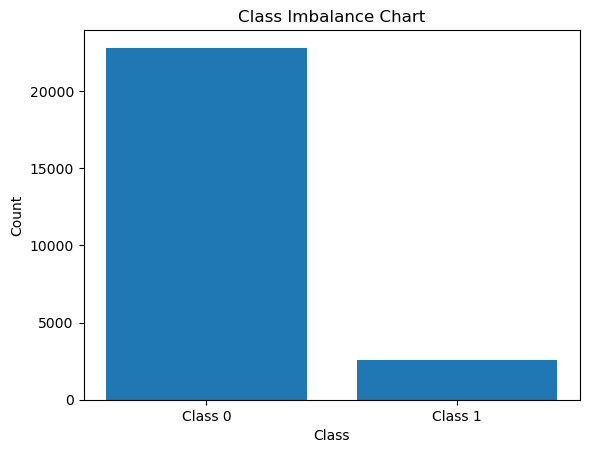

In [9]:
#class imbalance here - need to oversample
count_zeros = np.count_nonzero(y_train == 0)
print(count_zeros) #22800

count_ones = np.count_nonzero(y_train == 1)
print(count_ones) #2580

# Create labels for the classes
classes = ['Class 0', 'Class 1']

# Count of samples in each class
counts = [count_zeros, count_ones]

# Create a bar chart
plt.bar(classes, counts)

# Add labels and a title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Imbalance Chart')

# Display the chart
plt.show()

In [ ]:
#Over sample
from imblearn.over_sampling import SMOTE

# Instantiate the SMOTE object
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

from collections import Counter
counter = Counter(y_resampled)
print(counter)

